# Convolutional Neural Network for GDP Time Series Forecasting

In [1]:
# load relevant packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from cnn_model import CNN_1D
from windowing import WindowGenerator

%load_ext autoreload
%autoreload 2

In [2]:
# load cleaned data
df = pd.read_csv('data_cleaned.csv')
df.rename(columns={df.columns[0]: 'Index'}, inplace=True)
df.set_index('Index', inplace=True)

df

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Merchandise Imports By Commodity Division | Total Merchandise Imports,M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,Domestic Exports Of Major Non-Oil Products | Total Electronic Products,Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index,"Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total",Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate
Index,,,,,,,,,,,,,,,
1997-01-31,5.766667,111.147,15.715098,5.488212,93891.4,1.600448,9.938033,-5.407013,-0.636598,2.039052,5.333333,-4.953253,4.805478,-6.735186,-14.074074
1997-02-28,5.733333,109.571,-19.711470,0.511269,95647.4,-11.022186,6.894096,-3.535354,-5.900391,2.393572,3.666667,-1.013923,6.974227,-5.116564,-17.037037
1997-03-31,5.700000,118.447,3.658993,16.211454,94048.8,1.893330,9.790800,-6.288319,-5.065484,2.748092,2.000000,2.925407,9.142976,-3.497942,-20.000000
1997-04-30,6.966667,107.974,2.971000,9.481268,94470.6,2.179168,4.434663,2.294903,-1.744494,3.147185,8.666667,6.860232,10.549475,-3.759513,-20.277778
1997-05-31,8.233333,113.795,2.081662,7.937089,94257.8,6.845282,5.632341,0.208366,-7.157538,3.546278,15.333333,10.795056,11.955975,-4.021084,-20.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2.733333,94.672,3.528764,-6.174603,99219.0,-0.041443,3.938170,-3.701242,-20.219001,-3.943664,5.000000,-2.638300,1.877809,-5.648494,-16.190476
2022-12-31,2.100000,102.994,4.257838,-1.193731,99029.0,-8.242208,6.151695,-3.505964,-17.856474,-5.422222,3.000000,-0.911467,1.223659,-9.912281,-14.285714
2023-01-31,1.533333,99.578,-4.899654,-4.905048,85680.0,-11.227587,6.068394,-3.013121,-26.816758,-5.461702,3.333333,2.834411,0.420000,-5.828636,-16.190476


## Data Preprocessing

In this section, the following steps will be performed in sequence.

1. split data into train and test (0.8:0.2)
    - train duration: 1997 - 2017
    - test duration 2018 - 2023
2. Perform scaling on the dataset; specifically
    - fit transform train
    - transform test to prevent data leakage
    - X, y are scale separately so that the y_pred can be inverse_transform subsequently.

In [3]:
# manual split data so that we can train and test for specific year ranges
train = df[(df.index < "2018-01-31")].copy()
test = df[df.index >= "2018-01-31"].copy()
total = df.copy()
total_dateindex = df.index
train_dateindex = train.index
test_dateindex = test.index

In [131]:
target_col = 'Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars'
X = df.drop(target_col, axis =1)
y = df[target_col] 

X_train = X[(X.index < "2018-01-31")].copy()
X_test = X[X.index >= "2018-01-31"].copy()
y_train = y[(y.index < "2018-01-31")].copy()
y_test = y[y.index >= "2018-01-31"].copy()

scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = y_scaler.transform(y_test.values.reshape(-1,1))
X_total = scaler.transform(X)
y_total = y_scaler.transform(y.values.reshape(-1,1))

## Single Conv1d Model

In [5]:
batch_size=18

# train and test dataloaders for lookback=6, lookahead=1
lookback=6
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

In [6]:
train_dataloader1 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader1 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

In [9]:
# train_data = WindowGenerator(X_train, y_train).split_data()
# test_data = WindowGenerator(X_test,y_test).split_data()
# train_dataset = TimeSeriesDataset(train_data[0], train_data[1])
# test_dataset = TimeSeriesDataset(test_data[0], test_data[1])
# train_dataloader = DataLoader(train_dataset, batch_size=18, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=18, shuffle=True)

NameError: name 'TimeSeriesDataset' is not defined

torch.device => mps


  0%|                                                                             | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a ta

Epoch 1/200, Loss: 0.3584 Val loss:2.9142
Epoch 2/200, Loss: 0.1306 Val loss:1.7896
Epoch 3/200, Loss: 0.1266 Val loss:2.2508


  4%|██▍                                                                  | 7/200 [00:00<00:10, 18.63it/s]

Epoch 4/200, Loss: 0.0709 Val loss:2.0196
Epoch 5/200, Loss: 0.0421 Val loss:2.0003
Epoch 6/200, Loss: 0.0259 Val loss:1.9679
Epoch 7/200, Loss: 0.0229 Val loss:1.8117
Epoch 8/200, Loss: 0.0238 Val loss:1.7041


  6%|████▍                                                               | 13/200 [00:00<00:09, 20.50it/s]

Epoch 9/200, Loss: 0.0150 Val loss:1.8633
Epoch 10/200, Loss: 0.0160 Val loss:2.0747
Epoch 11/200, Loss: 0.0525 Val loss:1.4283
Epoch 12/200, Loss: 0.0115 Val loss:1.3796
Epoch 13/200, Loss: 0.1432 Val loss:3.4157


  8%|█████▍                                                              | 16/200 [00:00<00:08, 21.28it/s]

Epoch 14/200, Loss: 0.0556 Val loss:1.4719
Epoch 15/200, Loss: 0.0202 Val loss:1.8651
Epoch 16/200, Loss: 0.0147 Val loss:1.9065
Epoch 17/200, Loss: 0.0168 Val loss:1.7239
Epoch 18/200, Loss: 0.0112 Val loss:2.0635


 11%|███████▍                                                            | 22/200 [00:01<00:07, 23.33it/s]

Epoch 19/200, Loss: 0.0207 Val loss:1.6950
Epoch 20/200, Loss: 0.0110 Val loss:1.9434
Epoch 21/200, Loss: 0.0120 Val loss:1.8475
Epoch 22/200, Loss: 0.0118 Val loss:1.8142
Epoch 23/200, Loss: 0.0110 Val loss:1.9028
Epoch 24/200, Loss: 0.0111 Val loss:1.8977


 14%|█████████▌                                                          | 28/200 [00:01<00:07, 23.35it/s]

Epoch 25/200, Loss: 0.0131 Val loss:1.7011
Epoch 26/200, Loss: 0.0139 Val loss:1.9977
Epoch 27/200, Loss: 0.0107 Val loss:2.0747
Epoch 28/200, Loss: 0.0292 Val loss:1.4745
Epoch 29/200, Loss: 0.0383 Val loss:2.2281
Epoch 30/200, Loss: 0.0110 Val loss:2.2251


 17%|███████████▌                                                        | 34/200 [00:01<00:06, 24.43it/s]

Epoch 31/200, Loss: 0.0346 Val loss:1.3934
Epoch 32/200, Loss: 0.0534 Val loss:2.6004
Epoch 33/200, Loss: 0.0247 Val loss:1.5783
Epoch 34/200, Loss: 0.0140 Val loss:2.1093
Epoch 35/200, Loss: 0.0137 Val loss:1.7223


 20%|█████████████▌                                                      | 40/200 [00:01<00:06, 24.67it/s]

Epoch 36/200, Loss: 0.0125 Val loss:2.1614
Epoch 37/200, Loss: 0.0157 Val loss:1.6585
Epoch 38/200, Loss: 0.0156 Val loss:2.1971
Epoch 39/200, Loss: 0.0143 Val loss:1.6901
Epoch 40/200, Loss: 0.0131 Val loss:2.1286
Epoch 41/200, Loss: 0.0126 Val loss:1.7201


 23%|███████████████▋                                                    | 46/200 [00:02<00:06, 25.44it/s]

Epoch 42/200, Loss: 0.0129 Val loss:2.1547
Epoch 43/200, Loss: 0.0142 Val loss:1.6581
Epoch 44/200, Loss: 0.0162 Val loss:2.2391
Epoch 45/200, Loss: 0.0158 Val loss:1.6401
Epoch 46/200, Loss: 0.0148 Val loss:2.1723
Epoch 47/200, Loss: 0.0127 Val loss:1.6940


 26%|█████████████████▋                                                  | 52/200 [00:02<00:05, 25.03it/s]

Epoch 48/200, Loss: 0.0135 Val loss:2.2179
Epoch 49/200, Loss: 0.0161 Val loss:1.5500
Epoch 50/200, Loss: 0.0256 Val loss:2.4704
Epoch 51/200, Loss: 0.0279 Val loss:1.4784
Epoch 52/200, Loss: 0.0224 Val loss:2.2639
Epoch 53/200, Loss: 0.0123 Val loss:1.6826


 29%|███████████████████▋                                                | 58/200 [00:02<00:05, 26.04it/s]

Epoch 54/200, Loss: 0.0128 Val loss:2.2036
Epoch 55/200, Loss: 0.0157 Val loss:1.4490
Epoch 56/200, Loss: 0.0382 Val loss:2.5992
Epoch 57/200, Loss: 0.0370 Val loss:1.4507
Epoch 58/200, Loss: 0.0260 Val loss:2.2024
Epoch 59/200, Loss: 0.0100 Val loss:1.8755


 32%|█████████████████████▊                                              | 64/200 [00:02<00:05, 23.36it/s]

Epoch 60/200, Loss: 0.0115 Val loss:1.8653
Epoch 61/200, Loss: 0.0099 Val loss:1.8647
Epoch 62/200, Loss: 0.0102 Val loss:2.0429
Epoch 63/200, Loss: 0.0138 Val loss:1.6313
Epoch 64/200, Loss: 0.0171 Val loss:2.2234


 35%|███████████████████████▊                                            | 70/200 [00:02<00:05, 25.42it/s]

Epoch 65/200, Loss: 0.0157 Val loss:1.6556
Epoch 66/200, Loss: 0.0117 Val loss:2.0426
Epoch 67/200, Loss: 0.0102 Val loss:1.8282
Epoch 68/200, Loss: 0.0099 Val loss:1.9316
Epoch 69/200, Loss: 0.0099 Val loss:1.8314
Epoch 70/200, Loss: 0.0101 Val loss:1.9968


 38%|█████████████████████████▊                                          | 76/200 [00:03<00:04, 26.04it/s]

Epoch 71/200, Loss: 0.0112 Val loss:1.7241
Epoch 72/200, Loss: 0.0123 Val loss:2.0947
Epoch 73/200, Loss: 0.0125 Val loss:1.7123
Epoch 74/200, Loss: 0.0110 Val loss:2.0083
Epoch 75/200, Loss: 0.0100 Val loss:1.8181
Epoch 76/200, Loss: 0.0099 Val loss:1.9444


 40%|██████████████████████████▊                                         | 79/200 [00:03<00:04, 25.02it/s]

Epoch 77/200, Loss: 0.0100 Val loss:1.7459
Epoch 78/200, Loss: 0.0122 Val loss:2.1704
Epoch 79/200, Loss: 0.0182 Val loss:1.5442
Epoch 80/200, Loss: 0.0215 Val loss:2.2781
Epoch 81/200, Loss: 0.0137 Val loss:1.6999


 42%|████████████████████████████▉                                       | 85/200 [00:03<00:04, 24.57it/s]

Epoch 82/200, Loss: 0.0101 Val loss:1.9259
Epoch 83/200, Loss: 0.0104 Val loss:1.8307
Epoch 84/200, Loss: 0.0102 Val loss:2.1405
Epoch 85/200, Loss: 0.0205 Val loss:1.3741
Epoch 86/200, Loss: 0.0500 Val loss:2.7149
Epoch 87/200, Loss: 0.0421 Val loss:1.3739


 46%|██████████████████████████████▉                                     | 91/200 [00:03<00:04, 25.71it/s]

Epoch 88/200, Loss: 0.0237 Val loss:2.2575
Epoch 89/200, Loss: 0.0114 Val loss:1.5716
Epoch 90/200, Loss: 0.0136 Val loss:2.2273
Epoch 91/200, Loss: 0.0212 Val loss:1.4199
Epoch 92/200, Loss: 0.0277 Val loss:2.3625
Epoch 93/200, Loss: 0.0187 Val loss:1.5481


 48%|████████████████████████████████▉                                   | 97/200 [00:04<00:04, 25.61it/s]

Epoch 94/200, Loss: 0.0152 Val loss:2.1301
Epoch 95/200, Loss: 0.0116 Val loss:1.7286
Epoch 96/200, Loss: 0.0104 Val loss:1.9544
Epoch 97/200, Loss: 0.0101 Val loss:1.8297
Epoch 98/200, Loss: 0.0098 Val loss:1.8711
Epoch 99/200, Loss: 0.0098 Val loss:1.8730


 52%|██████████████████████████████████▌                                | 103/200 [00:04<00:03, 26.39it/s]

Epoch 100/200, Loss: 0.0099 Val loss:1.8456
Epoch 101/200, Loss: 0.0098 Val loss:1.8771
Epoch 102/200, Loss: 0.0098 Val loss:1.8546
Epoch 103/200, Loss: 0.0098 Val loss:1.8542
Epoch 104/200, Loss: 0.0098 Val loss:1.8774
Epoch 105/200, Loss: 0.0099 Val loss:1.8360


 55%|████████████████████████████████████▌                              | 109/200 [00:04<00:03, 27.35it/s]

Epoch 106/200, Loss: 0.0098 Val loss:1.8751
Epoch 107/200, Loss: 0.0098 Val loss:1.8561
Epoch 108/200, Loss: 0.0098 Val loss:1.8397
Epoch 109/200, Loss: 0.0098 Val loss:1.8828
Epoch 110/200, Loss: 0.0099 Val loss:1.8400
Epoch 111/200, Loss: 0.0098 Val loss:1.8366


 57%|██████████████████████████████████████▌                            | 115/200 [00:04<00:03, 27.90it/s]

Epoch 112/200, Loss: 0.0099 Val loss:1.9195
Epoch 113/200, Loss: 0.0104 Val loss:1.7670
Epoch 114/200, Loss: 0.0103 Val loss:1.9302
Epoch 115/200, Loss: 0.0098 Val loss:1.8550
Epoch 116/200, Loss: 0.0103 Val loss:1.7705
Epoch 117/200, Loss: 0.0114 Val loss:1.9704


 60%|████████████████████████████████████████▌                          | 121/200 [00:04<00:02, 28.24it/s]

Epoch 118/200, Loss: 0.0107 Val loss:1.8484
Epoch 119/200, Loss: 0.0104 Val loss:1.6413
Epoch 120/200, Loss: 0.0210 Val loss:2.3933
Epoch 121/200, Loss: 0.0308 Val loss:1.4532
Epoch 122/200, Loss: 0.0232 Val loss:2.2003
Epoch 123/200, Loss: 0.0099 Val loss:1.8397


 64%|██████████████████████████████████████████▌                        | 127/200 [00:05<00:02, 28.34it/s]

Epoch 124/200, Loss: 0.0122 Val loss:1.7608
Epoch 125/200, Loss: 0.0102 Val loss:1.7470
Epoch 126/200, Loss: 0.0106 Val loss:2.1459
Epoch 127/200, Loss: 0.0222 Val loss:1.3189
Epoch 128/200, Loss: 0.0400 Val loss:2.6602
Epoch 129/200, Loss: 0.0293 Val loss:1.2832
Epoch 130/200, Loss: 0.0235 

 67%|████████████████████████████████████████████▉                      | 134/200 [00:05<00:02, 28.41it/s]

Val loss:2.3133
Epoch 131/200, Loss: 0.0159 Val loss:1.3149
Epoch 132/200, Loss: 0.0286 Val loss:2.1770
Epoch 133/200, Loss: 0.0160 Val loss:1.5912
Epoch 134/200, Loss: 0.0166 Val loss:2.0652
Epoch 135/200, Loss: 0.0116 Val loss:1.7621


 70%|██████████████████████████████████████████████▉                    | 140/200 [00:05<00:02, 26.53it/s]

Epoch 136/200, Loss: 0.0098 Val loss:1.8478
Epoch 137/200, Loss: 0.0098 Val loss:1.8726
Epoch 138/200, Loss: 0.0099 Val loss:1.7981
Epoch 139/200, Loss: 0.0099 Val loss:1.8901
Epoch 140/200, Loss: 0.0099 Val loss:1.7940
Epoch 141/200, Loss: 0.0099 

 73%|████████████████████████████████████████████████▉                  | 146/200 [00:05<00:02, 26.88it/s]

Val loss:1.8860
Epoch 142/200, Loss: 0.0099 Val loss:1.7945
Epoch 143/200, Loss: 0.0098 Val loss:1.8806
Epoch 144/200, Loss: 0.0099 Val loss:1.7956
Epoch 145/200, Loss: 0.0098 Val loss:1.8785
Epoch 146/200, Loss: 0.0098 Val loss:1.7931


 76%|██████████████████████████████████████████████████▉                | 152/200 [00:06<00:01, 26.23it/s]

Epoch 147/200, Loss: 0.0098 Val loss:1.8808
Epoch 148/200, Loss: 0.0099 Val loss:1.7870
Epoch 149/200, Loss: 0.0098 Val loss:1.8872
Epoch 150/200, Loss: 0.0099 Val loss:1.7775
Epoch 151/200, Loss: 0.0099 Val loss:1.8986
Epoch 152/200, Loss: 0.0099 Val loss:1.7646


 78%|███████████████████████████████████████████████████▉               | 155/200 [00:06<00:01, 25.26it/s]

Epoch 153/200, Loss: 0.0100 Val loss:1.9148
Epoch 154/200, Loss: 0.0101 Val loss:1.7453
Epoch 155/200, Loss: 0.0101 Val loss:1.9382
Epoch 156/200, Loss: 0.0102 Val loss:1.7188
Epoch 157/200, Loss: 0.0104 Val loss:1.9717


 80%|█████████████████████████████████████████████████████▉             | 161/200 [00:06<00:01, 24.60it/s]

Epoch 158/200, Loss: 0.0106 Val loss:1.6803
Epoch 159/200, Loss: 0.0110 Val loss:2.0226
Epoch 160/200, Loss: 0.0113 Val loss:1.6315
Epoch 161/200, Loss: 0.0119 Val loss:2.0826
Epoch 162/200, Loss: 0.0121 Val loss:1.5737
Epoch 163/200, Loss: 0.0134 Val loss:2.1575


 84%|███████████████████████████████████████████████████████▉           | 167/200 [00:06<00:01, 24.45it/s]

Epoch 164/200, Loss: 0.0140 Val loss:1.4967
Epoch 165/200, Loss: 0.0162 Val loss:2.2056
Epoch 166/200, Loss: 0.0151 Val loss:1.4535
Epoch 167/200, Loss: 0.0169 Val loss:2.1966
Epoch 168/200, Loss: 0.0139 Val loss:1.4894


 86%|█████████████████████████████████████████████████████████▉         | 173/200 [00:06<00:01, 24.31it/s]

Epoch 169/200, Loss: 0.0157 Val loss:2.1430
Epoch 170/200, Loss: 0.0129 Val loss:1.5544
Epoch 171/200, Loss: 0.0137 Val loss:2.0660
Epoch 172/200, Loss: 0.0111 Val loss:1.6535
Epoch 173/200, Loss: 0.0106 Val loss:1.9586
Epoch 174/200, Loss: 0.0100 

 88%|██████████████████████████████████████████████████████████▉        | 176/200 [00:07<00:01, 23.97it/s]

Val loss:1.7170
Epoch 175/200, Loss: 0.0103 Val loss:1.9864
Epoch 176/200, Loss: 0.0118 Val loss:1.6333
Epoch 177/200, Loss: 0.0145 Val loss:2.0722
Epoch 178/200, Loss: 0.0123 Val loss:1.7162


 91%|████████████████████████████████████████████████████████████▉      | 182/200 [00:07<00:00, 24.31it/s]

Epoch 179/200, Loss: 0.0098 Val loss:1.8005
Epoch 180/200, Loss: 0.0123 Val loss:1.9801
Epoch 181/200, Loss: 0.0156 Val loss:1.7133
Epoch 182/200, Loss: 0.0107 Val loss:1.7244
Epoch 183/200, Loss: 0.0159 Val loss:2.2218


 94%|██████████████████████████████████████████████████████████████▉    | 188/200 [00:07<00:00, 24.52it/s]

Epoch 184/200, Loss: 0.0289 Val loss:1.4020
Epoch 185/200, Loss: 0.0283 Val loss:2.2140
Epoch 186/200, Loss: 0.0112 Val loss:1.5856
Epoch 187/200, Loss: 0.0101 Val loss:1.9718
Epoch 188/200, Loss: 0.0129 Val loss:1.5697
Epoch 189/200, Loss: 0.0128 Val loss:2.0777


 97%|████████████████████████████████████████████████████████████████▉  | 194/200 [00:07<00:00, 25.05it/s]

Epoch 190/200, Loss: 0.0126 Val loss:1.5164
Epoch 191/200, Loss: 0.0145 Val loss:2.1023
Epoch 192/200, Loss: 0.0127 Val loss:1.5216
Epoch 193/200, Loss: 0.0133 Val loss:2.0628
Epoch 194/200, Loss: 0.0122 Val loss:1.5526
Epoch 195/200, Loss: 0.0127 Val loss:2.0404


100%|███████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.89it/s]

Epoch 196/200, Loss: 0.0120 Val loss:1.5872
Epoch 197/200, Loss: 0.0120 Val loss:1.9995
Epoch 198/200, Loss: 0.0111 Val loss:1.6394
Epoch 199/200, Loss: 0.0108 Val loss:1.9513
Epoch 200/200, Loss: 0.0105 Val loss:1.6804


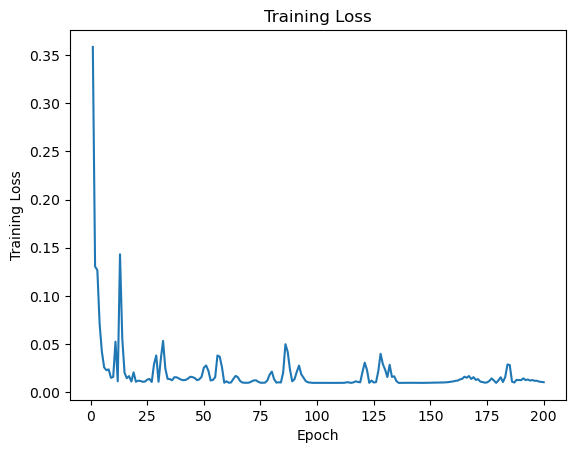

In [48]:
# Initialize the model and the optimizer
model_single = CNN_1D(n_features, lookback, layers ="single")
model_single.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_single.parameters(), lr=learning_rate)


model_single.fit(train_dataloader1, test_dataloader1, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=200)

In [31]:
model_single.evaluate(test_dataloader1, criterion, y_scaler)

Test Loss: 1.6561, MSE: 17.1373, RMSE: 3.3766, MAE: 2.9087


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely l

torch.device => mps


  0%|                                                                             | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a ta

Epoch 1/200, Loss: 0.0428 Val loss:2.5548
Epoch 2/200, Loss: 0.0383 Val loss:1.9934
Epoch 3/200, Loss: 0.0191 Val loss:1.5219
Epoch 4/200, Loss: 0.0212 Val loss:1.5900
Epoch 5/200, Loss: 0.0250 Val loss:2.0074


  3%|██                                                                   | 6/200 [00:00<00:07, 27.38it/s]

Epoch 6/200, Loss: 0.0251 Val loss:2.1201


  4%|███                                                                  | 9/200 [00:00<00:06, 27.32it/s]

Epoch 7/200, Loss: 0.0246 Val loss:2.1498
Epoch 8/200, Loss: 0.0226 Val loss:2.4585
Epoch 9/200, Loss: 0.0214 Val loss:2.4694
Epoch 10/200, Loss: 0.0197 Val loss:2.7072
Epoch 11/200, Loss: 0.0182 Val loss:2.6027


  6%|████                                                                | 12/200 [00:00<00:06, 27.53it/s]

Epoch 12/200, Loss: 0.0162 Val loss:2.7448


  8%|█████                                                               | 15/200 [00:00<00:06, 27.65it/s]

Epoch 13/200, Loss: 0.0153 Val loss:2.6168
Epoch 14/200, Loss: 0.0136 Val loss:2.6728
Epoch 15/200, Loss: 0.0132 Val loss:2.6782
Epoch 16/200, Loss: 0.0127 Val loss:2.5727
Epoch 17/200, Loss: 0.0123 Val loss:2.7221


  9%|██████                                                              | 18/200 [00:00<00:06, 26.56it/s]

Epoch 18/200, Loss: 0.0131 Val loss:2.6023


 10%|███████▏                                                            | 21/200 [00:00<00:06, 26.72it/s]

Epoch 19/200, Loss: 0.0115 Val loss:2.4462
Epoch 20/200, Loss: 0.0137 Val loss:2.9732
Epoch 21/200, Loss: 0.0222 Val loss:2.2528
Epoch 22/200, Loss: 0.0135 Val loss:2.6227
Epoch 23/200, Loss: 0.0131 Val loss:2.5538


 12%|████████▏                                                           | 24/200 [00:00<00:08, 21.15it/s]

Epoch 24/200, Loss: 0.0113 Val loss:2.1880
Epoch 25/200, Loss: 0.0162 Val loss:3.1863
Epoch 26/200, Loss: 0.0314 Val loss:1.8589


 14%|█████████▏                                                          | 27/200 [00:01<00:07, 22.42it/s]

Epoch 27/200, Loss: 0.0197 Val loss:3.1837
Epoch 28/200, Loss: 0.0158 Val loss:1.8222
Epoch 29/200, Loss: 0.0123 

 15%|██████████▏                                                         | 30/200 [00:01<00:07, 23.43it/s]

Val loss:2.8805
Epoch 30/200, Loss: 0.0121 Val loss:1.9882
Epoch 31/200, Loss: 0.0117 Val loss:2.3668
Epoch 32/200, Loss: 0.0123 Val loss:2.5663


 16%|███████████▏                                                        | 33/200 [00:01<00:06, 24.86it/s]

Epoch 33/200, Loss: 0.0124 Val loss:2.3169
Epoch 34/200, Loss: 0.0110 Val loss:2.5039


 18%|████████████▏                                                       | 36/200 [00:01<00:06, 24.31it/s]

Epoch 35/200, Loss: 0.0111 Val loss:2.4008
Epoch 36/200, Loss: 0.0110 Val loss:2.4672
Epoch 37/200, Loss: 0.0109 Val loss:2.4007
Epoch 38/200, Loss: 0.0108 Val loss:2.4473


 20%|█████████████▎                                                      | 39/200 [00:01<00:06, 24.85it/s]

Epoch 39/200, Loss: 0.0108 Val loss:2.4100
Epoch 40/200, Loss: 0.0106 Val loss:2.4387


 21%|██████████████▎                                                     | 42/200 [00:01<00:06, 24.78it/s]

Epoch 41/200, Loss: 0.0107 Val loss:2.4150
Epoch 42/200, Loss: 0.0106 Val loss:2.4388
Epoch 43/200, Loss: 0.0106 Val loss:2.4149


 22%|███████████████▎                                                    | 45/200 [00:01<00:06, 24.82it/s]

Epoch 44/200, Loss: 0.0105 Val loss:2.4369
Epoch 45/200, Loss: 0.0105 Val loss:2.4182


 24%|████████████████▎                                                   | 48/200 [00:01<00:05, 25.47it/s]

Epoch 46/200, Loss: 0.0104 Val loss:2.4329
Epoch 47/200, Loss: 0.0104 Val loss:2.4219
Epoch 48/200, Loss: 0.0104 Val loss:2.4263
Epoch 49/200, Loss: 0.0104 Val loss:2.4278


 26%|█████████████████▎                                                  | 51/200 [00:02<00:05, 26.03it/s]

Epoch 50/200, Loss: 0.0104 Val loss:2.4200
Epoch 51/200, Loss: 0.0103 Val loss:2.4337


 27%|██████████████████▎                                                 | 54/200 [00:02<00:05, 26.87it/s]

Epoch 52/200, Loss: 0.0103 Val loss:2.4182
Epoch 53/200, Loss: 0.0103 Val loss:2.4283
Epoch 54/200, Loss: 0.0103 Val loss:2.4287
Epoch 55/200, Loss: 0.0103 Val loss:2.4128


 28%|███████████████████▍                                                | 57/200 [00:02<00:05, 26.99it/s]

Epoch 56/200, Loss: 0.0103 Val loss:2.4447
Epoch 57/200, Loss: 0.0103 Val loss:2.4052


 30%|████████████████████▍                                               | 60/200 [00:02<00:05, 27.25it/s]

Epoch 58/200, Loss: 0.0102 Val loss:2.4356
Epoch 59/200, Loss: 0.0103 Val loss:2.4340
Epoch 60/200, Loss: 0.0103 Val loss:2.3917
Epoch 61/200, Loss: 0.0102 Val loss:2.4802


 32%|█████████████████████▍                                              | 63/200 [00:02<00:05, 27.32it/s]

Epoch 62/200, Loss: 0.0104 Val loss:2.3707
Epoch 63/200, Loss: 0.0103 Val loss:2.4452


 33%|██████████████████████▍                                             | 66/200 [00:02<00:04, 26.99it/s]

Epoch 64/200, Loss: 0.0103 Val loss:2.4602
Epoch 65/200, Loss: 0.0103 Val loss:2.3077
Epoch 66/200, Loss: 0.0106 Val loss:2.5955
Epoch 67/200, Loss: 0.0117 Val loss:2.2455


 34%|███████████████████████▍                                            | 69/200 [00:02<00:04, 27.47it/s]

Epoch 68/200, Loss: 0.0112 Val loss:2.5048
Epoch 69/200, Loss: 0.0110 Val loss:2.4066


 36%|████████████████████████▍                                           | 72/200 [00:02<00:04, 27.33it/s]

Epoch 70/200, Loss: 0.0102 Val loss:2.2769
Epoch 71/200, Loss: 0.0104 Val loss:2.7319
Epoch 72/200, Loss: 0.0131 Val loss:1.9605
Epoch 73/200, Loss: 0.0171 Val loss:2.9558
Epoch 74/200, Loss: 0.0191 Val loss:1.9326


 39%|██████████████████████████▌                                         | 78/200 [00:03<00:04, 26.99it/s]

Epoch 75/200, Loss: 0.0161 Val loss:2.8421
Epoch 76/200, Loss: 0.0128 Val loss:1.9816
Epoch 77/200, Loss: 0.0119 Val loss:2.8774
Epoch 78/200, Loss: 0.0115 Val loss:1.9194
Epoch 79/200, Loss: 0.0109 Val loss:2.6235
Epoch 80/200, Loss: 0.0109 Val loss:2.1221


 42%|████████████████████████████▉                                       | 85/200 [00:03<00:03, 28.80it/s]

Epoch 81/200, Loss: 0.0104 Val loss:2.3966
Epoch 82/200, Loss: 0.0103 Val loss:2.3603
Epoch 83/200, Loss: 0.0104 Val loss:2.3408
Epoch 84/200, Loss: 0.0102 Val loss:2.3691
Epoch 85/200, Loss: 0.0103 Val loss:2.3422
Epoch 86/200, Loss: 0.0102 Val loss:2.3682
Epoch 87/200, Loss: 0.0102 Val loss:2.3454


 46%|███████████████████████████████▎                                    | 92/200 [00:03<00:03, 29.70it/s]

Epoch 88/200, Loss: 0.0102 Val loss:2.3660
Epoch 89/200, Loss: 0.0102 Val loss:2.3479
Epoch 90/200, Loss: 0.0102 Val loss:2.3627
Epoch 91/200, Loss: 0.0102 Val loss:2.3523
Epoch 92/200, Loss: 0.0102 Val loss:2.3615
Epoch 93/200, Loss: 0.0102 Val loss:2.3559


 48%|████████████████████████████████▎                                   | 95/200 [00:03<00:03, 29.33it/s]

Epoch 94/200, Loss: 0.0101 Val loss:2.3614
Epoch 95/200, Loss: 0.0101 Val loss:2.3572
Epoch 96/200, Loss: 0.0101 Val loss:2.3608
Epoch 97/200, Loss: 0.0101 Val loss:2.3585


 49%|█████████████████████████████████▎                                  | 98/200 [00:03<00:04, 24.87it/s]

Epoch 98/200, Loss: 0.0101 Val loss:2.3608


 50%|█████████████████████████████████▊                                 | 101/200 [00:03<00:03, 26.02it/s]

Epoch 99/200, Loss: 0.0101 Val loss:2.3596
Epoch 100/200, Loss: 0.0101 Val loss:2.3606
Epoch 101/200, Loss: 0.0101 Val loss:2.3606
Epoch 102/200, Loss: 0.0101 Val loss:2.3605
Epoch 103/200, Loss: 0.0101 Val loss:2.3612


 52%|██████████████████████████████████▊                                | 104/200 [00:03<00:03, 27.03it/s]

Epoch 104/200, Loss: 0.0101 Val loss:2.3605
Epoch 105/200, Loss: 0.0101 

 54%|████████████████████████████████████▏                              | 108/200 [00:04<00:03, 28.36it/s]

Val loss:2.3613
Epoch 106/200, Loss: 0.0101 Val loss:2.3608
Epoch 107/200, Loss: 0.0101 Val loss:2.3613
Epoch 108/200, Loss: 0.0101 Val loss:2.3614
Epoch 109/200, Loss: 0.0101 Val loss:2.3607
Epoch 110/200, Loss: 0.0101 Val loss:2.3621
Epoch 111/200, Loss: 0.0101 Val loss:2.3605


 57%|██████████████████████████████████████▌                            | 115/200 [00:04<00:02, 29.12it/s]

Epoch 112/200, Loss: 0.0101 Val loss:2.3627
Epoch 113/200, Loss: 0.0101 Val loss:2.3604
Epoch 114/200, Loss: 0.0101 Val loss:2.3628
Epoch 115/200, Loss: 0.0101 Val loss:2.3607
Epoch 116/200, Loss: 0.0101 Val loss:2.3619
Epoch 117/200, Loss: 0.0101 Val loss:2.3625
Epoch 118/200, Loss: 0.0101 

 62%|█████████████████████████████████████████▏                         | 123/200 [00:04<00:02, 30.14it/s]

Val loss:2.3596
Epoch 119/200, Loss: 0.0101 Val loss:2.3657
Epoch 120/200, Loss: 0.0101 Val loss:2.3562
Epoch 121/200, Loss: 0.0101 Val loss:2.3686
Epoch 122/200, Loss: 0.0101 Val loss:2.3540
Epoch 123/200, Loss: 0.0101 Val loss:2.3682
Epoch 124/200, Loss: 0.0101 Val loss:2.3576


 64%|██████████████████████████████████████████▌                        | 127/200 [00:04<00:02, 31.12it/s]

Epoch 125/200, Loss: 0.0101 Val loss:2.3599
Epoch 126/200, Loss: 0.0101 Val loss:2.3725
Epoch 127/200, Loss: 0.0101 Val loss:2.3375
Epoch 128/200, Loss: 0.0101 Val loss:2.4012
Epoch 129/200, Loss: 0.0101 Val loss:2.3039
Epoch 130/200, Loss: 0.0102 Val loss:2.4301


 66%|███████████████████████████████████████████▉                       | 131/200 [00:04<00:02, 30.91it/s]

Epoch 131/200, Loss: 0.0103 Val loss:2.2892


 68%|█████████████████████████████████████████████▏                     | 135/200 [00:04<00:02, 32.32it/s]

Epoch 132/200, Loss: 0.0103 Val loss:2.4104
Epoch 133/200, Loss: 0.0104 Val loss:2.3543
Epoch 134/200, Loss: 0.0102 Val loss:2.2848
Epoch 135/200, Loss: 0.0101 Val loss:2.5502
Epoch 136/200, Loss: 0.0104 Val loss:2.0376
Epoch 137/200, Loss: 0.0118 Val loss:2.7884
Epoch 138/200, Loss: 0.0157 Val loss:1.8994


 72%|███████████████████████████████████████████████▉                   | 143/200 [00:05<00:01, 30.06it/s]

Epoch 139/200, Loss: 0.0185 Val loss:2.6477
Epoch 140/200, Loss: 0.0174 Val loss:2.1711
Epoch 141/200, Loss: 0.0159 Val loss:2.4811
Epoch 142/200, Loss: 0.0108 Val loss:2.3522
Epoch 143/200, Loss: 0.0102 Val loss:2.4860
Epoch 144/200, Loss: 0.0102 Val loss:2.3072


 74%|█████████████████████████████████████████████████▏                 | 147/200 [00:05<00:01, 29.60it/s]

Epoch 145/200, Loss: 0.0101 Val loss:2.6085
Epoch 146/200, Loss: 0.0104 Val loss:2.1685
Epoch 147/200, Loss: 0.0107 Val loss:2.7298
Epoch 148/200, Loss: 0.0113 Val loss:2.0449
Epoch 149/200, Loss: 0.0115 Val loss:2.7467


 75%|██████████████████████████████████████████████████▎                | 150/200 [00:05<00:01, 29.33it/s]

Epoch 150/200, Loss: 0.0114 Val loss:2.0249


 77%|███████████████████████████████████████████████████▌               | 154/200 [00:05<00:01, 30.38it/s]

Epoch 151/200, Loss: 0.0116 Val loss:2.6595
Epoch 152/200, Loss: 0.0107 Val loss:2.1388
Epoch 153/200, Loss: 0.0105 Val loss:2.5435
Epoch 154/200, Loss: 0.0102 Val loss:2.2590
Epoch 155/200, Loss: 0.0101 Val loss:2.4565
Epoch 156/200, Loss: 0.0101 Val loss:2.3479
Epoch 157/200, Loss: 0.0101 Val loss:2.4135


 80%|█████████████████████████████████████████████████████▉             | 161/200 [00:05<00:01, 28.95it/s]

Epoch 158/200, Loss: 0.0101 Val loss:2.3841
Epoch 159/200, Loss: 0.0101 Val loss:2.3990
Epoch 160/200, Loss: 0.0101 Val loss:2.3939
Epoch 161/200, Loss: 0.0101 Val loss:2.3974
Epoch 162/200, Loss: 0.0101 Val loss:2.3966
Epoch 163/200, Loss: 0.0101 Val loss:2.3974


 84%|███████████████████████████████████████████████████████▉           | 167/200 [00:06<00:01, 28.54it/s]

Epoch 164/200, Loss: 0.0101 Val loss:2.3972
Epoch 165/200, Loss: 0.0101 Val loss:2.3977
Epoch 166/200, Loss: 0.0101 Val loss:2.3976
Epoch 167/200, Loss: 0.0101 Val loss:2.3980
Epoch 168/200, Loss: 0.0101 Val loss:2.3978
Epoch 169/200, Loss: 0.0101 Val loss:2.3982
Epoch 170/200, Loss: 0.0101 Val loss:2.3980


 88%|██████████████████████████████████████████████████████████▋        | 175/200 [00:06<00:00, 30.17it/s]

Epoch 171/200, Loss: 0.0101 Val loss:2.3983
Epoch 172/200, Loss: 0.0101 Val loss:2.3979
Epoch 173/200, Loss: 0.0101 Val loss:2.3982
Epoch 174/200, Loss: 0.0101 Val loss:2.3978
Epoch 175/200, Loss: 0.0101 Val loss:2.3980
Epoch 176/200, Loss: 0.0101 Val loss:2.3979


 90%|███████████████████████████████████████████████████████████▉       | 179/200 [00:06<00:00, 30.53it/s]

Epoch 177/200, Loss: 0.0101 Val loss:2.3980
Epoch 178/200, Loss: 0.0101 Val loss:2.3979
Epoch 179/200, Loss: 0.0101 Val loss:2.3979
Epoch 180/200, Loss: 0.0101 Val loss:2.3978
Epoch 181/200, Loss: 0.0101 Val loss:2.3977
Epoch 182/200, Loss: 0.0101 Val loss:2.3977


 92%|█████████████████████████████████████████████████████████████▎     | 183/200 [00:06<00:00, 30.48it/s]

Epoch 183/200, Loss: 0.0101 Val loss:2.3975


 94%|██████████████████████████████████████████████████████████████▋    | 187/200 [00:06<00:00, 30.12it/s]

Epoch 184/200, Loss: 0.0101 Val loss:2.3976
Epoch 185/200, Loss: 0.0101 Val loss:2.3973
Epoch 186/200, Loss: 0.0101 Val loss:2.3975
Epoch 187/200, Loss: 0.0101 Val loss:2.3972
Epoch 188/200, Loss: 0.0101 Val loss:2.3972
Epoch 189/200, Loss: 0.0101 Val loss:2.3972
Epoch 190/200, Loss: 0.0101 Val loss:2.3968


 98%|█████████████████████████████████████████████████████████████████▎ | 195/200 [00:06<00:00, 30.38it/s]

Epoch 191/200, Loss: 0.0101 Val loss:2.3972
Epoch 192/200, Loss: 0.0101 Val loss:2.3964
Epoch 193/200, Loss: 0.0101 Val loss:2.3973
Epoch 194/200, Loss: 0.0101 Val loss:2.3960
Epoch 195/200, Loss: 0.0101 Val loss:2.3973
Epoch 196/200, Loss: 0.0101 Val loss:2.3956
Epoch 197/200, Loss: 0.0101 Val loss:2.3971


100%|███████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.15it/s]


Epoch 198/200, Loss: 0.0101 Val loss:2.3957
Epoch 199/200, Loss: 0.0101 Val loss:2.3964
Epoch 200/200, Loss: 0.0101 Val loss:2.3964


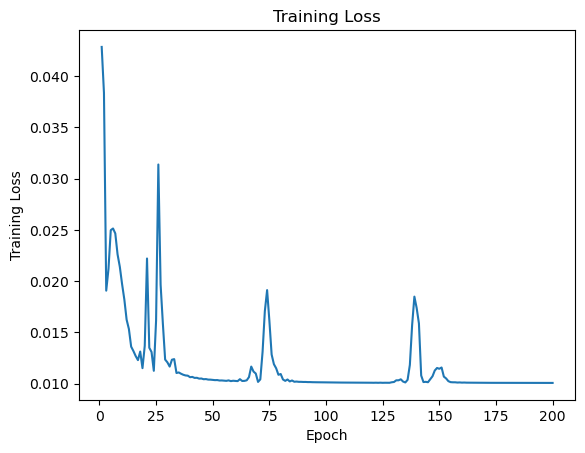

In [32]:
batch_size=32

# train and test dataloaders for lookback=6, lookahead=1
lookback=12
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

train_dataloader2 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader2 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

# Initialize the model and the optimizer
model_single2 = CNN_1D(n_features, lookback, layers ="single")
model_single2.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_single2.parameters(), lr=learning_rate)


model_single2.fit(train_dataloader2, test_dataloader2, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=200)

In [41]:
model_single2.evaluate(test_dataloader2, criterion, y_scaler)

what is y_batch <class 'torch.Tensor'>, torch.Size([32])
what is y_pred <class 'torch.Tensor'>, torch.Size([32, 1])
what is y_batch <class 'torch.Tensor'>, torch.Size([18])
what is y_pred <class 'torch.Tensor'>, torch.Size([18, 1])
Test Loss: 2.6331, MSE: 45.3221, RMSE: 6.6617, MAE: 5.7382


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.device => mps


  0%|                                                                       | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target s

Epoch 1/200, Loss: 0.0101 Val loss:2.3102
Epoch 2/200, Loss: 0.0103 Val loss:2.1660
Epoch 3/200, Loss: 0.0103 Val loss:2.3110
Epoch 4/200, Loss: 0.0101 Val loss:2.2380


  3%|█▉                                                             | 6/200 [00:00<00:06, 27.98it/s]

Epoch 5/200, Loss: 0.0101 Val loss:2.2551
Epoch 6/200, Loss: 0.0101 Val loss:2.2700
Epoch 7/200, Loss: 0.0101 Val loss:2.2460
Epoch 8/200, Loss: 0.0101 Val loss:2.2743
Epoch 9/200, Loss: 0.0101 

  6%|███▋                                                          | 12/200 [00:00<00:08, 22.67it/s]

Val loss:2.2438
Epoch 10/200, Loss: 0.0101 Val loss:2.2834
Epoch 11/200, Loss: 0.0101 Val loss:2.2255
Epoch 12/200, Loss: 0.0101 Val loss:2.3199


  8%|████▋                                                         | 15/200 [00:00<00:08, 22.59it/s]

Epoch 13/200, Loss: 0.0101 Val loss:2.1709
Epoch 14/200, Loss: 0.0102 Val loss:2.3869
Epoch 15/200, Loss: 0.0103 Val loss:2.1188
Epoch 16/200, Loss: 0.0105 Val loss:2.3093
Epoch 17/200, Loss: 0.0103 Val loss:2.2262


 10%|██████▌                                                       | 21/200 [00:00<00:08, 21.54it/s]

Epoch 18/200, Loss: 0.0104 Val loss:2.2321
Epoch 19/200, Loss: 0.0102 Val loss:2.2589
Epoch 20/200, Loss: 0.0102 Val loss:2.2359
Epoch 21/200, Loss: 0.0101 Val loss:2.2578


 12%|███████▍                                                      | 24/200 [00:01<00:08, 20.02it/s]

Epoch 22/200, Loss: 0.0101 Val loss:2.2443
Epoch 23/200, Loss: 0.0101 Val loss:2.2518
Epoch 24/200, Loss: 0.0101 Val loss:2.2498
Epoch 25/200, Loss: 0.0101 Val loss:2.2497
Epoch 26/200, Loss: 0.0101 

 15%|█████████▎                                                    | 30/200 [00:01<00:07, 22.08it/s]

Val loss:2.2504
Epoch 27/200, Loss: 0.0101 Val loss:2.2494
Epoch 28/200, Loss: 0.0101 Val loss:2.2502
Epoch 29/200, Loss: 0.0101 Val loss:2.2490
Epoch 30/200, Loss: 0.0101 Val loss:2.2514


 16%|██████████▏                                                   | 33/200 [00:01<00:08, 20.80it/s]

Epoch 31/200, Loss: 0.0101 Val loss:2.2477
Epoch 32/200, Loss: 0.0101 Val loss:2.2536
Epoch 33/200, Loss: 0.0101 Val loss:2.2444
Epoch 34/200, Loss: 0.0101 Val loss:2.2592
Epoch 35/200, Loss: 0.0101 Val loss:2.2353


 20%|████████████                                                  | 39/200 [00:01<00:07, 22.65it/s]

Epoch 36/200, Loss: 0.0101 Val loss:2.2749
Epoch 37/200, Loss: 0.0101 Val loss:2.2091
Epoch 38/200, Loss: 0.0101 Val loss:2.3205
Epoch 39/200, Loss: 0.0101 Val loss:2.1401
Epoch 40/200, Loss: 0.0101 Val loss:2.4076
Epoch 41/200, Loss: 0.0101 Val loss:2.0680


 22%|█████████████▉                                                | 45/200 [00:02<00:06, 24.13it/s]

Epoch 42/200, Loss: 0.0101 Val loss:2.3034
Epoch 43/200, Loss: 0.0102 Val loss:2.2033
Epoch 44/200, Loss: 0.0103 Val loss:2.1857
Epoch 45/200, Loss: 0.0104 Val loss:2.2520


 24%|██████████████▉                                               | 48/200 [00:02<00:07, 20.43it/s]

Epoch 46/200, Loss: 0.0105 Val loss:2.1799
Epoch 47/200, Loss: 0.0109 Val loss:2.2350
Epoch 48/200, Loss: 0.0106 Val loss:2.2065
Epoch 49/200, Loss: 0.0105 Val loss:2.2343


 27%|████████████████▋                                             | 54/200 [00:02<00:07, 20.76it/s]

Epoch 50/200, Loss: 0.0102 Val loss:2.2230
Epoch 51/200, Loss: 0.0101 Val loss:2.2346
Epoch 52/200, Loss: 0.0101 Val loss:2.2307
Epoch 53/200, Loss: 0.0101 Val loss:2.2324
Epoch 54/200, Loss: 0.0101 Val loss:2.2314


 28%|█████████████████▋                                            | 57/200 [00:02<00:06, 22.03it/s]

Epoch 55/200, Loss: 0.0101 Val loss:2.2327
Epoch 56/200, Loss: 0.0101 Val loss:2.2312
Epoch 57/200, Loss: 0.0101 Val loss:2.2318
Epoch 58/200, Loss: 0.0101 Val loss:2.2313
Epoch 59/200, Loss: 0.0101 Val loss:2.2317


 32%|███████████████████▌                                          | 63/200 [00:02<00:06, 21.13it/s]

Epoch 60/200, Loss: 0.0101 Val loss:2.2312
Epoch 61/200, Loss: 0.0101 Val loss:2.2317
Epoch 62/200, Loss: 0.0101 Val loss:2.2311
Epoch 63/200, Loss: 0.0101 Val loss:2.2317


 34%|█████████████████████▍                                        | 69/200 [00:03<00:05, 22.05it/s]

Epoch 64/200, Loss: 0.0101 Val loss:2.2311
Epoch 65/200, Loss: 0.0101 Val loss:2.2317
Epoch 66/200, Loss: 0.0101 Val loss:2.2309
Epoch 67/200, Loss: 0.0101 Val loss:2.2318
Epoch 68/200, Loss: 0.0101 Val loss:2.2307
Epoch 69/200, Loss: 0.0101 Val loss:2.2320


 36%|██████████████████████▎                                       | 72/200 [00:03<00:05, 22.67it/s]

Epoch 70/200, Loss: 0.0101 Val loss:2.2304
Epoch 71/200, Loss: 0.0101 Val loss:2.2325
Epoch 72/200, Loss: 0.0101 Val loss:2.2298
Epoch 73/200, Loss: 0.0101 Val loss:2.2334
Epoch 74/200, Loss: 0.0101 Val loss:2.2285


 39%|████████████████████████▏                                     | 78/200 [00:03<00:05, 22.18it/s]

Epoch 75/200, Loss: 0.0101 Val loss:2.2353
Epoch 76/200, Loss: 0.0101 Val loss:2.2257
Epoch 77/200, Loss: 0.0101 Val loss:2.2396
Epoch 78/200, Loss: 0.0101 Val loss:2.2191
Epoch 79/200, Loss: 0.0101 Val loss:2.2499


 42%|██████████████████████████                                    | 84/200 [00:03<00:04, 24.39it/s]

Epoch 80/200, Loss: 0.0101 Val loss:2.2032
Epoch 81/200, Loss: 0.0101 Val loss:2.2754
Epoch 82/200, Loss: 0.0101 Val loss:2.1649
Epoch 83/200, Loss: 0.0101 Val loss:2.3351
Epoch 84/200, Loss: 0.0101 Val loss:2.0864
Epoch 85/200, Loss: 0.0102 Val loss:2.3967


 45%|███████████████████████████▉                                  | 90/200 [00:04<00:04, 24.58it/s]

Epoch 86/200, Loss: 0.0102 Val loss:2.0320
Epoch 87/200, Loss: 0.0104 Val loss:2.2820
Epoch 88/200, Loss: 0.0103 Val loss:2.1669
Epoch 89/200, Loss: 0.0104 Val loss:2.1974
Epoch 90/200, Loss: 0.0104 Val loss:2.2163


 48%|█████████████████████████████▊                                | 96/200 [00:04<00:04, 25.93it/s]

Epoch 91/200, Loss: 0.0106 Val loss:2.1952
Epoch 92/200, Loss: 0.0105 Val loss:2.2143
Epoch 93/200, Loss: 0.0106 Val loss:2.2177
Epoch 94/200, Loss: 0.0103 Val loss:2.2151
Epoch 95/200, Loss: 0.0102 Val loss:2.2266
Epoch 96/200, Loss: 0.0101 Val loss:2.2172


 51%|███████████████████████████████                              | 102/200 [00:04<00:03, 26.87it/s]

Epoch 97/200, Loss: 0.0101 Val loss:2.2309
Epoch 98/200, Loss: 0.0101 Val loss:2.2202
Epoch 99/200, Loss: 0.0101 Val loss:2.2279
Epoch 100/200, Loss: 0.0101 Val loss:2.2224
Epoch 101/200, Loss: 0.0101 Val loss:2.2253
Epoch 102/200, Loss: 0.0101 Val loss:2.2232


 52%|████████████████████████████████                             | 105/200 [00:04<00:03, 26.86it/s]

Epoch 103/200, Loss: 0.0101 Val loss:2.2247
Epoch 104/200, Loss: 0.0101 Val loss:2.2235
Epoch 105/200, Loss: 0.0101 Val loss:2.2242
Epoch 106/200, Loss: 0.0101 Val loss:2.2236
Epoch 107/200, Loss: 0.0101 Val loss:2.2240


 56%|█████████████████████████████████▊                           | 111/200 [00:04<00:03, 24.07it/s]

Epoch 108/200, Loss: 0.0101 Val loss:2.2236
Epoch 109/200, Loss: 0.0101 Val loss:2.2240
Epoch 110/200, Loss: 0.0101 Val loss:2.2236
Epoch 111/200, Loss: 0.0101 Val loss:2.2240
Epoch 112/200, Loss: 0.0101 Val loss:2.2236


 58%|███████████████████████████████████▋                         | 117/200 [00:05<00:03, 24.48it/s]

Epoch 113/200, Loss: 0.0101 Val loss:2.2241
Epoch 114/200, Loss: 0.0101 Val loss:2.2235
Epoch 115/200, Loss: 0.0101 Val loss:2.2241
Epoch 116/200, Loss: 0.0101 Val loss:2.2235
Epoch 117/200, Loss: 0.0101 Val loss:2.2243


 60%|████████████████████████████████████▌                        | 120/200 [00:05<00:03, 22.55it/s]

Epoch 118/200, Loss: 0.0101 Val loss:2.2234
Epoch 119/200, Loss: 0.0101 Val loss:2.2245
Epoch 120/200, Loss: 0.0101 Val loss:2.2231
Epoch 121/200, Loss: 0.0101 Val loss:2.2249
Epoch 122/200, Loss: 0.0101 Val loss:2.2227


 63%|██████████████████████████████████████▍                      | 126/200 [00:05<00:03, 24.46it/s]

Epoch 123/200, Loss: 0.0101 Val loss:2.2255
Epoch 124/200, Loss: 0.0101 Val loss:2.2219
Epoch 125/200, Loss: 0.0101 Val loss:2.2267
Epoch 126/200, Loss: 0.0101 Val loss:2.2202
Epoch 127/200, Loss: 0.0101 Val loss:2.2291
Epoch 128/200, Loss: 0.0101 Val loss:2.2169


 66%|████████████████████████████████████████▎                    | 132/200 [00:05<00:02, 24.74it/s]

Epoch 129/200, Loss: 0.0101 Val loss:2.2340
Epoch 130/200, Loss: 0.0101 Val loss:2.2097
Epoch 131/200, Loss: 0.0101 Val loss:2.2445
Epoch 132/200, Loss: 0.0101 Val loss:2.1942
Epoch 133/200, Loss: 0.0101 Val loss:2.2676


 68%|█████████████████████████████████████████▏                   | 135/200 [00:05<00:02, 23.78it/s]

Epoch 134/200, Loss: 0.0101 Val loss:2.1596
Epoch 135/200, Loss: 0.0101 Val loss:2.3134
Epoch 136/200, Loss: 0.0101 Val loss:2.0967


 70%|███████████████████████████████████████████                  | 141/200 [00:06<00:02, 21.89it/s]

Epoch 137/200, Loss: 0.0102 Val loss:2.3659
Epoch 138/200, Loss: 0.0102 Val loss:2.0378
Epoch 139/200, Loss: 0.0103 Val loss:2.3069
Epoch 140/200, Loss: 0.0103 Val loss:2.1102
Epoch 141/200, Loss: 0.0104 Val loss:2.2228
Epoch 142/200, Loss: 0.0107 Val loss:2.2898


 74%|████████████████████████████████████████████▊                | 147/200 [00:06<00:02, 24.29it/s]

Epoch 143/200, Loss: 0.0115 Val loss:2.1181
Epoch 144/200, Loss: 0.0108 Val loss:2.1647
Epoch 145/200, Loss: 0.0112 Val loss:2.1204
Epoch 146/200, Loss: 0.0109 Val loss:2.1744
Epoch 147/200, Loss: 0.0110 Val loss:2.2210
Epoch 148/200, Loss: 0.0102 Val loss:2.1813


 76%|██████████████████████████████████████████████▋              | 153/200 [00:06<00:01, 25.90it/s]

Epoch 149/200, Loss: 0.0101 Val loss:2.2115
Epoch 150/200, Loss: 0.0101 Val loss:2.1921
Epoch 151/200, Loss: 0.0101 Val loss:2.2106
Epoch 152/200, Loss: 0.0101 Val loss:2.2118
Epoch 153/200, Loss: 0.0101 Val loss:2.2084
Epoch 154/200, Loss: 0.0101 Val loss:2.2095


 80%|████████████████████████████████████████████████▍            | 159/200 [00:06<00:01, 26.79it/s]

Epoch 155/200, Loss: 0.0101 Val loss:2.2071
Epoch 156/200, Loss: 0.0101 Val loss:2.2083
Epoch 157/200, Loss: 0.0101 Val loss:2.2072
Epoch 158/200, Loss: 0.0101 Val loss:2.2079
Epoch 159/200, Loss: 0.0101 Val loss:2.2071
Epoch 160/200, Loss: 0.0101 Val loss:2.2071


 82%|██████████████████████████████████████████████████▎          | 165/200 [00:07<00:01, 26.37it/s]

Epoch 161/200, Loss: 0.0101 Val loss:2.2069
Epoch 162/200, Loss: 0.0101 Val loss:2.2068
Epoch 163/200, Loss: 0.0101 Val loss:2.2067
Epoch 164/200, Loss: 0.0101 Val loss:2.2066
Epoch 165/200, Loss: 0.0101 Val loss:2.2065
Epoch 166/200, Loss: 0.0101 Val loss:2.2064


 86%|████████████████████████████████████████████████████▏        | 171/200 [00:07<00:01, 25.26it/s]

Epoch 167/200, Loss: 0.0101 Val loss:2.2063
Epoch 168/200, Loss: 0.0101 Val loss:2.2062
Epoch 169/200, Loss: 0.0101 Val loss:2.2062
Epoch 170/200, Loss: 0.0101 Val loss:2.2061
Epoch 171/200, Loss: 0.0101 Val loss:2.2061


 88%|█████████████████████████████████████████████████████▉       | 177/200 [00:07<00:00, 26.54it/s]

Epoch 172/200, Loss: 0.0101 Val loss:2.2060
Epoch 173/200, Loss: 0.0101 Val loss:2.2060
Epoch 174/200, Loss: 0.0101 Val loss:2.2060
Epoch 175/200, Loss: 0.0101 Val loss:2.2059
Epoch 176/200, Loss: 0.0101 Val loss:2.2059
Epoch 177/200, Loss: 0.0101 Val loss:2.2059


 92%|███████████████████████████████████████████████████████▊     | 183/200 [00:07<00:00, 27.92it/s]

Epoch 178/200, Loss: 0.0101 Val loss:2.2058
Epoch 179/200, Loss: 0.0101 Val loss:2.2058
Epoch 180/200, Loss: 0.0101 Val loss:2.2058
Epoch 181/200, Loss: 0.0101 Val loss:2.2058
Epoch 182/200, Loss: 0.0101 Val loss:2.2058
Epoch 183/200, Loss: 0.0101 Val loss:2.2058


 94%|█████████████████████████████████████████████████████████▋   | 189/200 [00:07<00:00, 28.12it/s]

Epoch 184/200, Loss: 0.0101 Val loss:2.2058
Epoch 185/200, Loss: 0.0101 Val loss:2.2058
Epoch 186/200, Loss: 0.0101 Val loss:2.2057
Epoch 187/200, Loss: 0.0101 Val loss:2.2058
Epoch 188/200, Loss: 0.0101 Val loss:2.2057
Epoch 189/200, Loss: 0.0101 Val loss:2.2058


 98%|███████████████████████████████████████████████████████████▍ | 195/200 [00:08<00:00, 28.47it/s]

Epoch 190/200, Loss: 0.0101 Val loss:2.2057
Epoch 191/200, Loss: 0.0101 Val loss:2.2058
Epoch 192/200, Loss: 0.0101 Val loss:2.2056
Epoch 193/200, Loss: 0.0101 Val loss:2.2058
Epoch 194/200, Loss: 0.0101 Val loss:2.2056
Epoch 195/200, Loss: 0.0101 Val loss:2.2059


100%|█████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.03it/s]


Epoch 196/200, Loss: 0.0101 Val loss:2.2054
Epoch 197/200, Loss: 0.0101 Val loss:2.2061
Epoch 198/200, Loss: 0.0101 Val loss:2.2051
Epoch 199/200, Loss: 0.0101 Val loss:2.2066
Epoch 200/200, Loss: 0.0101 Val loss:2.2045


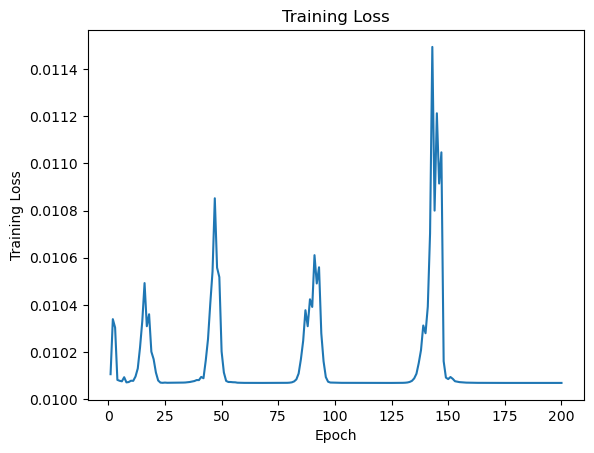

In [148]:
batch_size=18

# train and test dataloaders for lookback=6, lookahead=1
lookback=6
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

total_dataloader3 = WindowGenerator(X_total, y_total,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

train_dataloader3 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader3 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

# Initialize the model and the optimizer
model_single3 = CNN_1D(n_features, lookback, layers ="single")
model_single3.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_single2.parameters(), lr=learning_rate)


model_single2.fit(train_dataloader2, test_dataloader2, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=200)

In [141]:
model_single3.evaluate(test_dataloader3, criterion, y_scaler)

what is y_batch <class 'torch.Tensor'>, torch.Size([32])
what is y_pred <class 'torch.Tensor'>, torch.Size([32, 1])
what is y_batch <class 'torch.Tensor'>, torch.Size([18])
what is y_pred <class 'torch.Tensor'>, torch.Size([18, 1])
Test Loss: 2.0027, MSE: 40.3793, RMSE: 5.8675, MAE: 5.0607


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Multi Layer Conv1d Model

In [156]:
batch_size=18

# train and test dataloaders for lookback=6, lookahead=1
lookback=12
lookahead=1
learning_rate = 0.001
n_features = 15
num_epochs = 200

total_dataloader3 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

train_dataloader3 = WindowGenerator(X_train, y_train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size).make_dataloader()

test_dataloader3 = WindowGenerator(X_test, y_test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size).make_dataloader()

# Initialize the model and the optimizer
model_multi = CNN_1D(n_features, lookback, layers ="multi")
model_multi.set_device()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_multi.parameters(), lr=learning_rate)


model_multi.fit(train_dataloader3, test_dataloader3, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=200)

/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


torch.device => mps


  0%|                                                                       | 0/200 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/pn/qz12b_x55lx3hjqmrpty0b_00000gn/T/ipykernel_62428/3398568622.py", line 32, in <module>
    model_multi.fit(train_dataloader3, test_dataloader3, num_epochs,
  File "/Users/walter/code/aml-cs610/nowcasting/nowcasting/cnn_model.py", line 297, in fit
    outputs = self.forward(x_batch)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/walter/code/aml-cs610/nowcasting/nowcasting/cnn_model.py", line 271, in forward
    x = self.pool(x)
        ^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3

In [153]:
model_multi.evaluate(test_dataloader3, criterion, y_scaler)

what is y_batch <class 'torch.Tensor'>, torch.Size([18])
what is y_pred <class 'torch.Tensor'>, torch.Size([18, 1])
what is y_batch <class 'torch.Tensor'>, torch.Size([18])
what is y_pred <class 'torch.Tensor'>, torch.Size([18, 1])
what is y_batch <class 'torch.Tensor'>, torch.Size([14])
what is y_pred <class 'torch.Tensor'>, torch.Size([14, 1])
Test Loss: 1.8209, MSE: 17.9598, RMSE: 4.1791, MAE: 3.1871


/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/envs/dfm2/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Visualize Results

In [135]:
import matplotlib.dates as mdates

def plot_predictions(model, 
                     test_loader, 
                     test_dateindex,
                     lookback,
                     lookahead,
                     y_scaler,
                     title=""
                     ):
    y_pred = model.predict(torch.Tensor(np.array(test_loader.dataset.X)))
    y_pred = y_pred.cpu().detach()
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1))
    
    start = lookback
    end = len(test_dateindex) - lookahead
    # start = 0
    # end = len(test_dateindex)    

    fig, axs = plt.subplots(1,1, figsize=(10,8), constrained_layout=True)
    true_y = y_scaler.inverse_transform(test_loader.dataset.y.reshape(-1,1))

    # for ax in axs.ravel():
    axs.plot(test_dateindex[start:end], 
            true_y, 
            linewidth=1, alpha=0.5, 
            color='#000099', label='y_true')

    axs.plot(test_dateindex[start:end], 
            y_pred, 
            linewidth=1, alpha=0.5, 
            color='#ff0000', label='y_pred')

    axs.legend()

    axs.set_title(title)
    plt.xticks(rotation=45)
    x_labels = axs.get_xticklabels()
    for i, label in enumerate(x_labels):
        if i % 6 != 0:
            label.set_visible(False)

    plt.show()

In [89]:
type(test_dataloader1.dataset.X)

numpy.ndarray

In [110]:
test_dateindex

Index(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
       '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
       '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
       '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
       '2023-01-31', '2023-02-28', '2023-03-31'],
      dtype='object', name

In [109]:
type(test_dateindex[0])

str

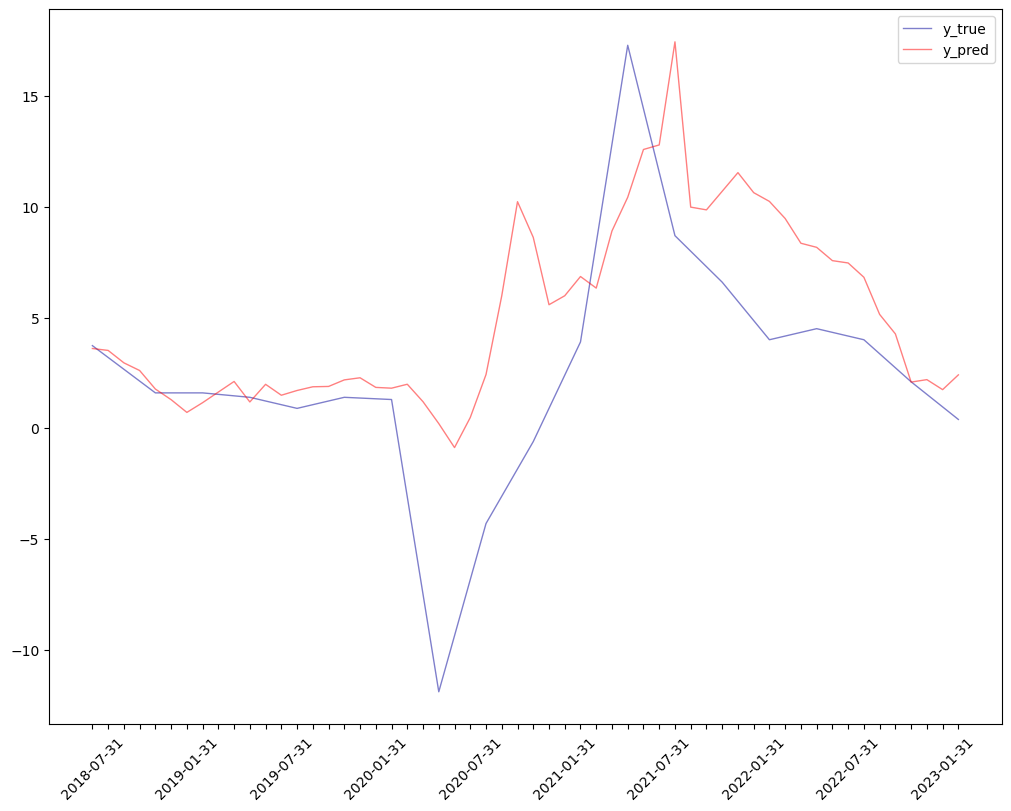

In [147]:
lookback = 6
lookahead = 1
plot_predictions(model_single, test_dataloader1,
                 test_dateindex, lookback, lookahead, y_scaler)

ValueError: x and y must have same first dimension, but have shapes (290,) and (239, 1)

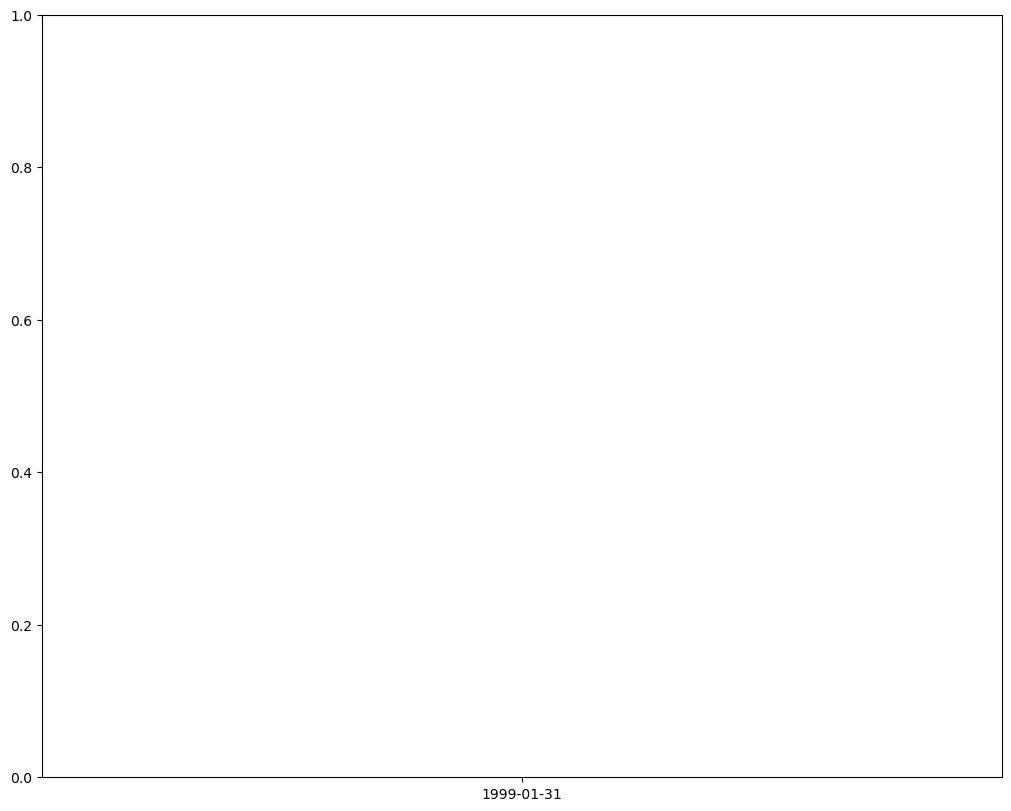

In [154]:
# model_multi.evaluate(test_dataloader3, criterion, y_scaler)

lookback = 24
lookahead = 1
plot_predictions(model_multi, test_dataloader3,
                 test_dateindex, lookback, lookahead, y_scaler)

In [126]:
import torch.nn as nn
import torch.optim as optim
from cnn_model import CNN_1d

# Initialize the model and the optimizer
model_cnn1d_1s = CNN_1d(n_features, lookback)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_cnn1d_1s.parameters(), lr=learning_rate)

num_epochs = 1000
model_cnn1d_1s.fit(train_loader_1m, test_loader_1m, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=50)

  1%|▍                                                                   | 6/1000 [00:00<00:36, 27.48it/s]

Epoch 1/1000, Loss: 0.2443, Val loss:1.2920
Epoch 2/1000, Loss: 0.0570, Val loss:0.6989
Epoch 3/1000, Loss: 0.0583, Val loss:0.6467
Epoch 4/1000, Loss: 0.0311, Val loss:0.5311
Epoch 5/1000, Loss: 0.0217, Val loss:0.5092
Epoch 6/1000, Loss: 0.0120, Val loss:0.4937


  1%|▊                                                                  | 12/1000 [00:00<00:35, 27.80it/s]

Epoch 7/1000, Loss: 0.0109, Val loss:0.4200
Epoch 8/1000, Loss: 0.0057, Val loss:0.3904
Epoch 9/1000, Loss: 0.0266, Val loss:0.4695
Epoch 10/1000, Loss: 0.0596, Val loss:1.0807
Epoch 11/1000, Loss: 0.0388, Val loss:0.7190
Epoch 12/1000, Loss: 0.0787, Val loss:0.6035


  2%|█▏                                                                 | 18/1000 [00:00<00:35, 27.95it/s]

Epoch 13/1000, Loss: 0.1168, Val loss:0.8762
Epoch 14/1000, Loss: 0.0074, Val loss:0.3623
Epoch 15/1000, Loss: 0.0250, Val loss:0.5668
Epoch 16/1000, Loss: 0.0060, Val loss:0.3771
Epoch 17/1000, Loss: 0.0105, Val loss:0.4810
Epoch 18/1000, Loss: 0.0035, Val loss:0.3832


  2%|█▌                                                                 | 24/1000 [00:00<00:34, 28.44it/s]

Epoch 19/1000, Loss: 0.0054, Val loss:0.4516
Epoch 20/1000, Loss: 0.0019, Val loss:0.4112
Epoch 21/1000, Loss: 0.0018, Val loss:0.4256
Epoch 22/1000, Loss: 0.0040, Val loss:0.4429
Epoch 23/1000, Loss: 0.0014, Val loss:0.4265
Epoch 24/1000, Loss: 0.0029, Val loss:0.4032


  3%|██                                                                 | 30/1000 [00:01<00:33, 29.06it/s]

Epoch 25/1000, Loss: 0.0089, Val loss:0.4618
Epoch 26/1000, Loss: 0.0014, Val loss:0.4536
Epoch 27/1000, Loss: 0.0109, Val loss:0.3744
Epoch 28/1000, Loss: 0.0173, Val loss:0.4767
Epoch 29/1000, Loss: 0.0020, Val loss:0.4910
Epoch 30/1000, Loss: 0.0155, Val loss:0.3606


  3%|██▏                                                                | 33/1000 [00:01<00:33, 28.97it/s]

Epoch 31/1000, Loss: 0.0150, Val loss:0.4695
Epoch 32/1000, Loss: 0.0030, Val loss:0.5146
Epoch 33/1000, Loss: 0.0187, Val loss:0.3699
Epoch 34/1000, Loss: 0.0122, Val loss:0.4696
Epoch 35/1000, Loss: 0.0051, Val loss:0.5214
Epoch 36/1000, Loss: 0.0191, Val loss:0.3835


  4%|██▋                                                                | 40/1000 [00:01<00:36, 26.06it/s]

Epoch 37/1000, Loss: 0.0095, Val loss:0.4481
Epoch 38/1000, Loss: 0.0046, Val loss:0.5032
Epoch 39/1000, Loss: 0.0117, Val loss:0.3883
Epoch 40/1000, Loss: 0.0039, Val loss:0.4351
Epoch 41/1000, Loss: 0.0040, Val loss:0.4970


  5%|███                                                                | 46/1000 [00:01<00:35, 26.90it/s]

Epoch 42/1000, Loss: 0.0084, Val loss:0.3931
Epoch 43/1000, Loss: 0.0010, Val loss:0.4152
Epoch 44/1000, Loss: 0.0076, Val loss:0.5227
Epoch 45/1000, Loss: 0.0076, Val loss:0.3999
Epoch 46/1000, Loss: 0.0009, Val loss:0.3823
Epoch 47/1000, Loss: 0.0220, Val loss:0.5862
Epoch 48/1000, Loss: 0.0059, 

  5%|███▌                                                               | 53/1000 [00:01<00:36, 26.14it/s]

Val loss:0.4308
Epoch 49/1000, Loss: 0.0106, Val loss:0.3608
Epoch 50/1000, Loss: 0.0491, Val loss:0.6958
Epoch 51/1000, Loss: 0.0044, Val loss:0.4607
Epoch 52/1000, Loss: 0.0089, Val loss:0.3609
Epoch 53/1000, Loss: 0.0231, Val loss:0.5980


  6%|███▊                                                               | 56/1000 [00:02<00:36, 25.82it/s]

Epoch 54/1000, Loss: 0.0041, Val loss:0.4128
Epoch 55/1000, Loss: 0.0009, Val loss:0.3955
Epoch 56/1000, Loss: 0.0028, Val loss:0.4736
Epoch 57/1000, Loss: 0.0017, Val loss:0.4095
Epoch 58/1000, Loss: 0.0003, Val loss:0.4163
Epoch 59/1000, Loss: 0.0009, Val loss:0.4508


  6%|████▏                                                              | 63/1000 [00:02<00:36, 25.80it/s]

Epoch 60/1000, Loss: 0.0007, Val loss:0.4207
Epoch 61/1000, Loss: 0.0002, Val loss:0.4228
Epoch 62/1000, Loss: 0.0007, Val loss:0.4521
Epoch 63/1000, Loss: 0.0005, Val loss:0.4282
Epoch 64/1000, Loss: 0.0002, Val loss:0.4212


  7%|████▊                                                              | 71/1000 [00:02<00:33, 27.91it/s]

Epoch 65/1000, Loss: 0.0010, Val loss:0.4588
Epoch 66/1000, Loss: 0.0004, Val loss:0.4372
Epoch 67/1000, Loss: 0.0007, Val loss:0.4120
Epoch 68/1000, Loss: 0.0022, Val loss:0.4681
Epoch 69/1000, Loss: 0.0002, Val loss:0.4584
Epoch 70/1000, Loss: 0.0039, Val loss:0.3954
Epoch 71/1000, Loss: 0.0051, Val loss:0.4713


  7%|████▉                                                              | 74/1000 [00:02<00:34, 27.16it/s]

Epoch 72/1000, Loss: 0.0011, Val loss:0.5106
Epoch 73/1000, Loss: 0.0143, Val loss:0.3818
Epoch 74/1000, Loss: 0.0077, Val loss:0.4492
Epoch 75/1000, Loss: 0.0082, Val loss:0.5883
Epoch 76/1000, Loss: 0.0193, Val loss:0.3928
Epoch 77/1000, Loss: 0.0024, Val loss:0.4070


  8%|█████▎                                                             | 79/1000 [00:02<00:34, 26.39it/s]

Epoch 78/1000, Loss: 0.0197, Val loss:0.6329
Epoch 79/1000, Loss: 0.0123, Val loss:0.4129
Epoch 80/1000, Loss: 0.0022, Val loss:0.3631
Early stopping at epoch 80


In [127]:
model_cnn1d_1s.evaluate(test_loader_1m, criterion, y_scaler)

tensor([[-0.3554],
        [-0.4762],
        [-0.5970],
        [-0.7178],
        [-0.8386],
        [-0.8386],
        [-0.8386],
        [-0.8386],
        [-0.8537],
        [-0.8688],
        [-0.8839],
        [-0.9216],
        [-0.9594],
        [-0.9971],
        [-0.9594],
        [-0.9216],
        [-0.8839],
        [-0.8914]])
x
tensor([[-0.2680],
        [-0.2835],
        [-0.2969],
        [-0.2713],
        [-0.3959],
        [-0.6654],
        [-0.9229],
        [-0.9639],
        [-1.3301],
        [-1.1208],
        [-1.1228],
        [-1.2112],
        [-1.0729],
        [-1.0387],
        [-1.0065],
        [-0.7979],
        [-0.8030],
        [-0.8880]])
tensor([[-0.8990],
        [-0.9065],
        [-1.9031],
        [-2.8996],
        [-3.8961],
        [-3.3223],
        [-2.7486],
        [-2.1748],
        [-1.8955],
        [-1.6162],
        [-1.3369],
        [-0.9971],
        [-0.6574],
        [-0.3177],
        [ 0.6939],
        [ 1.7055],
        

In [20]:
#### HELPER - PLOT FORECAST ####
import matplotlib.pyplot as plt

def plot_predictions(model, 
                     test_loader, 
                     test_dateindex,
                     lookback,
                     lookahead
                     ):
    y_pred = model.predict(test_loader.dataset.X)
    y_pred = y_pred.cpu().detach()

    start = lookback
    end = len(test_dateindex) - lookahead

    fig, axs = plt.subplots(1,1, figsize=(10,8), constrained_layout=True)

    # for ax in axs.ravel():
    axs.plot(test_dateindex[start:end], 
            test_loader.dataset.y, 
            linewidth=0.7, alpha=0.5, 
            color='#000099', label='y_true')

    axs.plot(test_dateindex[start:end], 
            y_pred, 
            linewidth=0.7, alpha=0.5, 
            color='#ff0000', label='y_pred')

    axs.legend()

    axs.set_title('full year')
    # axs[1].set_title('first 30 days')
    # axs[2].set_title('last 30 days')
    # axs[1].set_xlim(test_dateindex[start], test_dateindex[start+24*30])
    # axs[2].set_xlim(test_dateindex[end-24*30], test_dateindex[end])
    

In [58]:
model_cnn1d_1s.evaluate(test_loader_1m, criterion)

Test Loss: 0.4842, RMSE: 0.6397, MAE: 0.5287


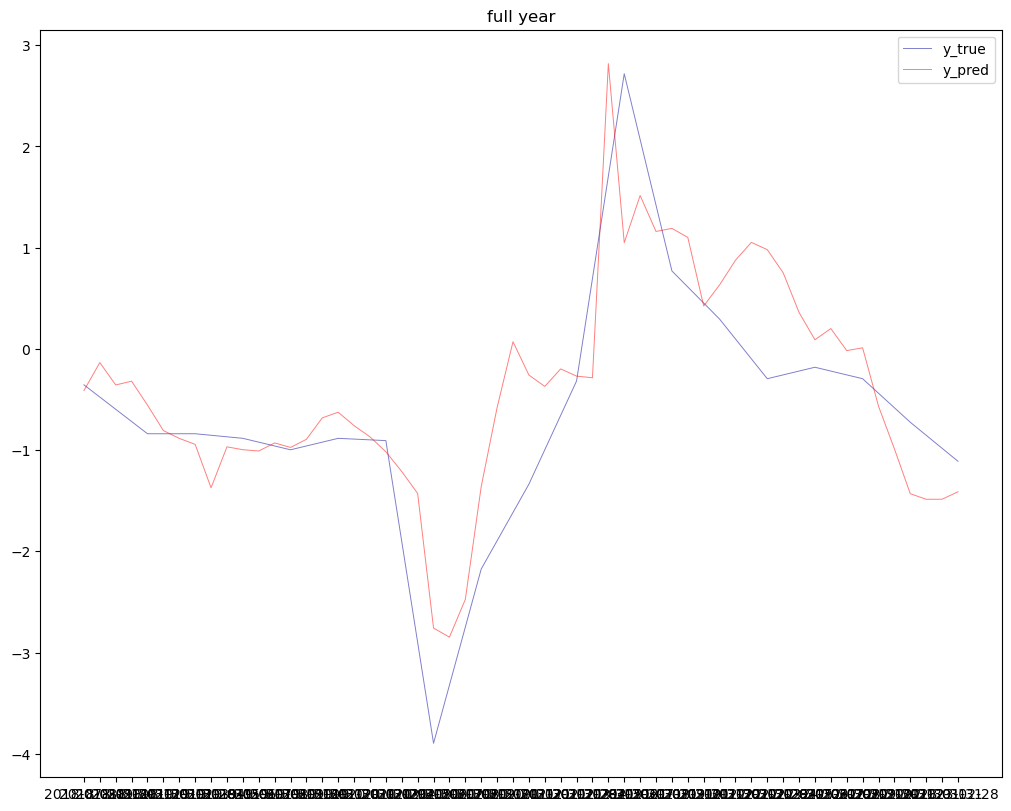

In [114]:
lookback = 6
lookahead = 1
plot_predictions(model_cnn1d_1s, test_loader_1m,
                 test_dateindex, lookback, lookahead)

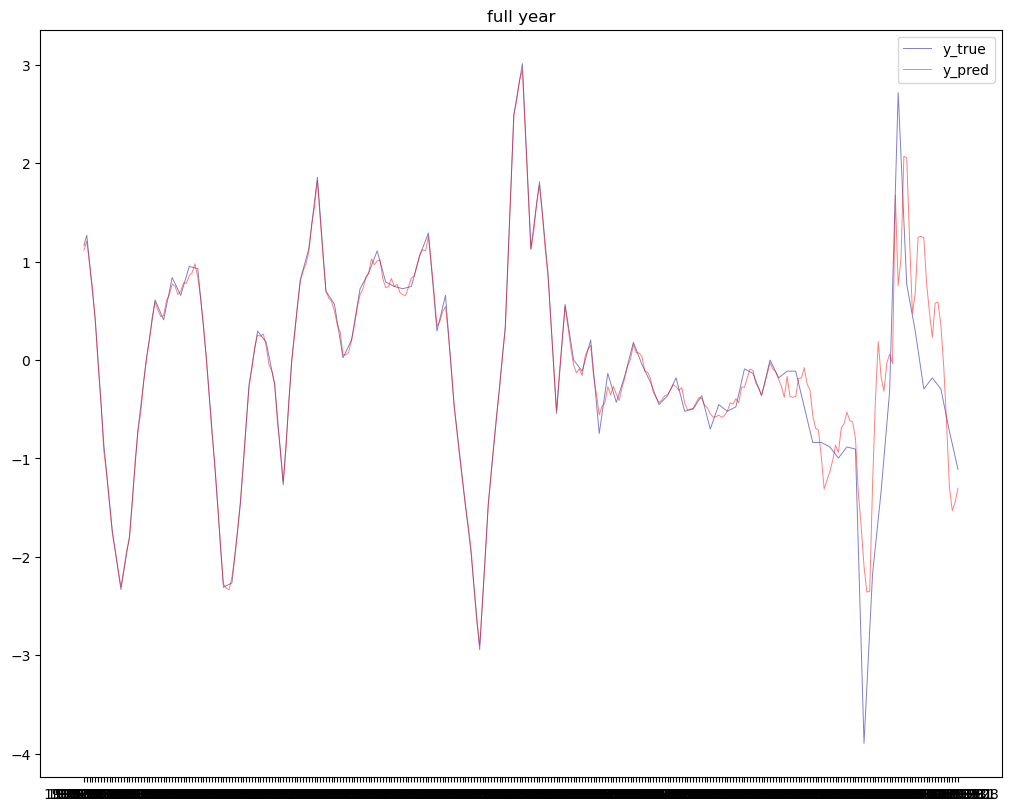

In [ ]:
lookback = 6
lookahead = 1
plot_predictions(model_cnn1d_1s, total_loader_1m,
                 total_dateindex, lookback, lookahead)

In [61]:
batch_size=18

# train and test dataloaders for lookback=7, lookahead=3
lookback=7
lookahead=3
num_epochs = 30
learning_rate = 0.001
n_features = 15

In [62]:


total_loader_3m = WindowGenerator(total,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size,
                                  label_idx=0).make_dataloader()

train_loader_3m = WindowGenerator(train,
                                  lookback=lookback,
                                  lookahead=lookahead,
                                  batch_size=batch_size,
                                  label_idx=0).make_dataloader()

test_loader_3m = WindowGenerator(test,
                                 lookback=lookback,
                                 lookahead=lookahead,
                                 batch_size=batch_size,
                                 label_idx=0).make_dataloader()

In [63]:
# Debug code to verify data loading and batching
print("Train Loader Data:")
for x_batch, y_batch in train_loader_3m:
    print("Input Shape:", x_batch.shape)
    print("Target Shape:", y_batch.shape)
    break  # Print only the first batch for brevity

print("\nTest Loader Data:")
for x_batch, y_batch in test_loader_3m:
    print("Input Shape:", x_batch.shape)
    print("Target Shape:", y_batch.shape)
    break  # Print only the first batch for brevity


Train Loader Data:
Input Shape: torch.Size([18, 7, 15])
Target Shape: torch.Size([18, 1])

Test Loader Data:
Input Shape: torch.Size([18, 7, 15])
Target Shape: torch.Size([18, 1])


In [67]:
import torch.nn as nn
import torch.optim as optim
from cnn_model import CNN_1d

# Initialize the model and the optimizer
model_cnn1d_3s = CNN_1d(n_features, lookback)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model_cnn1d_3s.parameters(), lr=learning_rate)

model_cnn1d_3s.fit(train_loader_3m, test_loader_3m, num_epochs,
                    criterion, optimizer, min_delta=1e-4, patience=10)

 10%|███████                                                               | 3/30 [00:00<00:01, 23.49it/s]

Epoch 1/30, Loss: 0.4260, Val loss:2.7320
Epoch 2/30, Loss: 0.2249, Val loss:1.7301
Epoch 3/30, Loss: 0.1429, Val loss:1.6168
Epoch 4/30, Loss: 0.0720, Val loss:1.4858
Epoch 5/30, Loss: 0.0333, Val loss:1.0368


 30%|█████████████████████                                                 | 9/30 [00:00<00:00, 23.40it/s]

Epoch 6/30, Loss: 0.0343, Val loss:0.9943
Epoch 7/30, Loss: 0.0268, Val loss:1.1030
Epoch 8/30, Loss: 0.0293, Val loss:1.7952
Epoch 9/30, Loss: 0.0461, Val loss:1.7817
Epoch 10/30, Loss: 0.1833, Val loss:0.7978


 50%|██████████████████████████████████▌                                  | 15/30 [00:00<00:00, 25.57it/s]

Epoch 11/30, Loss: 0.1876, Val loss:1.5777
Epoch 12/30, Loss: 0.1215, Val loss:2.0169
Epoch 13/30, Loss: 0.0170, Val loss:0.9337
Epoch 14/30, Loss: 0.0435, Val loss:1.7084
Epoch 15/30, Loss: 0.0160, Val loss:0.8749
Epoch 16/30, Loss: 0.0214, Val loss:1.5334


 63%|███████████████████████████████████████████▋                         | 19/30 [00:00<00:00, 23.67it/s]

Epoch 17/30, Loss: 0.0186, Val loss:0.9738
Epoch 18/30, Loss: 0.0122, Val loss:1.3080
Epoch 19/30, Loss: 0.0103, Val loss:1.2221
Epoch 20/30, Loss: 0.0106, Val loss:1.0757
Early stopping at epoch 20


In [68]:
model_cnn1d_3s.evaluate(test_loader_3m, criterion)

Test Loss: 1.0727, RMSE: 0.9614, MAE: 0.8016


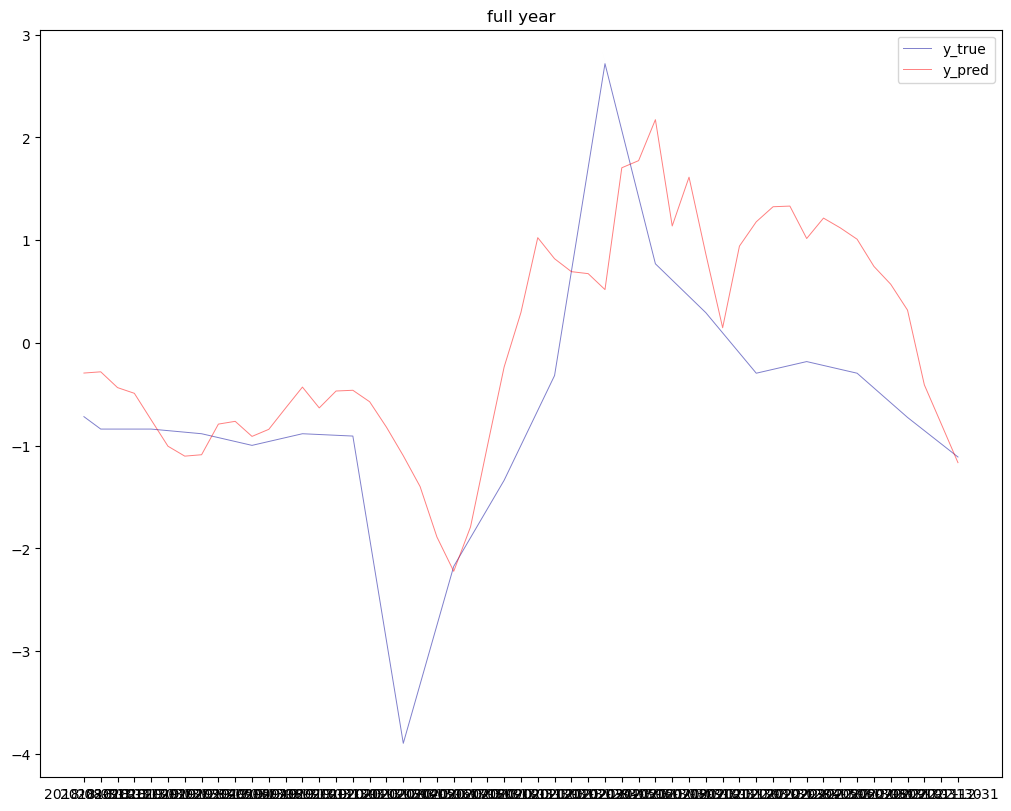

In [69]:
lookback = 7
lookahead = 3
plot_predictions(model_cnn1d_3s, test_loader_3m,
                 test_dateindex, lookback, lookahead)

In [89]:
# assuming from previous dataset of 
# 6 lookback and 1 lookforward

class CNN1D(nn.Module):
    def __init__(self, num_features, seq_len):
        super().__init__()
        self.conv0 = nn.Conv1d(in_channels=num_features,out_channels = 3, kernel_size = 1)
        self.conv1 = nn.Conv1d(in_channels=num_features,out_channels = 3, kernel_size = 3,padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_features,out_channels = 3, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool1d(kernel_size = 3,dilation=1)
        self.linear = nn.Linear(in_features=seq_len*3,out_features=1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = x.permute(0,2,1)
        x0 = self.conv0(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x = torch.cat((x0,x1,x2),dim=1)
        x = self.maxpool1(x)
        x = torch.flatten(x,1)
        x = F.relu(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = F.relu(x)
        return x
    

In [ ]:
conv1d = CNN1D(num_features=11, seq_len=6).to(device)